## Дисклеймер

Согласно семинару разбора подходов к данному домашнему заданию от Леонида Саночкина, дальнейшее повествование, комментарии и названия столбцев и строк в таблицах будут на английском языке.

In [27]:
import pandas as pd
import numpy as np
import seaborn as sns

## train.csv

Inspecting train.csv first (going by the order of features as given in the homework)

In [2]:
dtypes = {
    "row_id": "int64",
    "timestamp": "int64",
    "user_id": "int32",
    "content_id": "int16",
    "content_type_id": "boolean",
    "task_container_id": "int16",
    "user_answer": "int8",
    "answered_correctly": "int8",
    "prior_question_elapsed_time": "float32", 
    "prior_question_had_explanation": "boolean"
}

train = pd.read_csv("C:/Users/basx/Desktop/riiid-test-answer-prediction/train.csv", dtype=dtypes)

print("Train size:", train.shape)

Train size: (101230332, 10)


Seems like the data set is extremely large. It's dimensions are given by the train.shape above. 101 million rows by 10 columns.
Each feature explanation was provided during the assignment of this homework, so I will not list them here.

In [5]:
train.head(50) # first 50 rows

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,False,1,3,1,NaN,<NA>
1,1,56943,115,5716,False,2,2,1,37000.0,False
2,2,118363,115,128,False,0,0,1,55000.0,False
3,3,131167,115,7860,False,3,0,1,19000.0,False
4,4,137965,115,7922,False,4,1,1,11000.0,False
5,5,157063,115,156,False,5,2,1,5000.0,False
6,6,176092,115,51,False,6,0,1,17000.0,False
7,7,194190,115,50,False,7,3,1,17000.0,False
8,8,212463,115,7896,False,8,2,1,16000.0,False
9,9,230983,115,7863,False,9,0,1,16000.0,False


Above is a table for the first 50 rows of the dataset. By looking at it you can clearly see that,
raw data is sorted by **user_id** in ascending order. <br>
Student with **user_id == 115** had a total of **46** interactions with both lectures and questions. <br>
Column **content_type_id** was changed to boolean, because it only represents two types of events: **reading a lecture** and **answering a question**. <br>
*For example we can tell that student with user id of 115 has not read a single lecture, because all of the entries for content_type_id are False* <br>

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101230332 entries, 0 to 101230331
Data columns (total 10 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   row_id                          int64  
 1   timestamp                       int64  
 2   user_id                         int32  
 3   content_id                      int16  
 4   content_type_id                 boolean
 5   task_container_id               int16  
 6   user_answer                     int8   
 7   answered_correctly              int8   
 8   prior_question_elapsed_time     float32
 9   prior_question_had_explanation  boolean
dtypes: boolean(2), float32(1), int16(2), int32(1), int64(2), int8(2)
memory usage: 3.2 GB


In [8]:
print(f'We have {train.user_id.nunique()} unique users in our train set')

We have 393656 unique users in our train set


In [61]:
train_ids = train.content_id.nunique()
train_qs = train[train.content_type_id == False].content_id.nunique()
print(f'We have {train_ids} content ids in our train set, of which {train_qs} are questions.')

ratio_qs_to_ids = (train_qs / train_ids) * 100
print(f'The percentage of questions out of all ids is equal to: {ratio_qs_to_ids:.2f}%')

We have 13782 content ids in our train set, of which 13523 are questions.
The percentage of questions out of all ids is equal to: 98.12%


We have calculated that **98.1%** of the content is questions.

Looking at the first 50 rows of the table (see above), **user_answer** seems to fluctuate between 0 and 3. We don't know yet, whether the first 50 rows represent the true picture. <br> <br>
**Hypothesis: The questions are multiple choice questions with 3-4 choices provided** <br><br>
Let's test if this is true!


In [55]:
multiple_choice_vars = train.user_answer.value_counts()
print(multiple_choice_vars)

 0    28186489
 1    26990007
 3    26084784
 2    18010020
-1     1959032
Name: user_answer, dtype: int64


   answer variant     count
0               0  28186489
1               1  26990007
2               3  26084784
3               2  18010020
4              -1   1959032


<AxesSubplot:xlabel='answer variant', ylabel='count'>

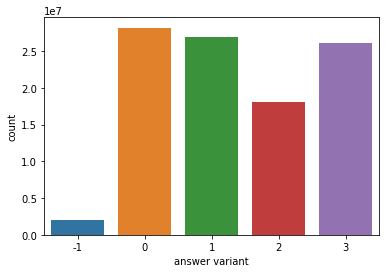

In [57]:
mcv = pd.DataFrame(data={'answer variant':[0,1,3,2,-1], 'count': [28186489, 26990007, 26084784, 18010020, 1959032]})
print(mcv)

sns.barplot(data=mcv, x = 'answer variant', y = 'count')

In [60]:
percent_lectures = 1959032/ sum(multiple_choice_vars) * 100
print(f'Lectures as a percent of all student interactions: {percent_lectures:.2f}%')

Lectures as a percent of all student interactions: 1.94%


From the barplot it is clear to us lectures (-1 answer variant) make up for a non-significant percentage of total student interactions. <br> 
We have also determined the total number of variants on a question interaction is indeed 4. **Thus proving the hypothesis**. <br>
On another note we have found an interesting discovery: <br>
third answer variant is the least popular answer on a multiple choice quiz (the red bar is a lot shorter than the rest).<br>
This could be due to a questionaire bias (if the creator of the question didn't truly randomise which answer variant the correct answer goes into). Otherwise it could be a psychological effect that needs studying.

In [63]:
#getting rid of the lecture interactions of -1
correct = train[train.answered_correctly != -1].answered_correctly.value_counts(ascending=True)
print(correct)

0    34026673
1    65244627
Name: answered_correctly, dtype: int64


<AxesSubplot:xlabel='answer variant', ylabel='count'>

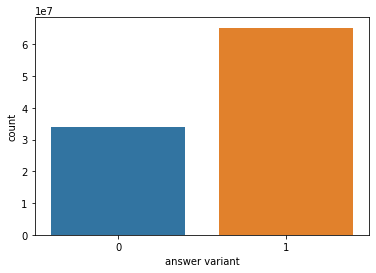

In [64]:
corr = pd.DataFrame(data={'answer variant':[0,1], 'count':[34026673, 65244627]})
sns.barplot(data=corr, x = 'answer variant', y = 'count')

Plot above is my best estimation of a chance for a random student to answer a question correctly (without further knowledge of linear regression and more advanced methods we haven't studied yet).<br>
Approximately **65%** of interactions with questions (excluding lectures) have a correct answer and **~35%** ended with a wrong answer.

<AxesSubplot:xlabel='prior_question_elapsed_time', ylabel='answered_correctly'>

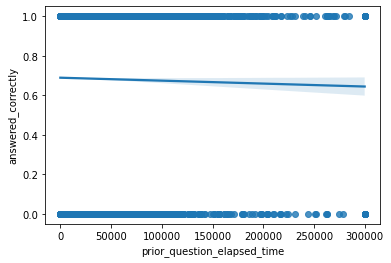

In [69]:
sns.regplot(data = train[:100000], x ='prior_question_elapsed_time', y = 'answered_correctly')

Plot above demonstrates if there's a correlation between time spent on a question and whether it was answered correctly, for a slice of data from the 0 row to the 100000 (as anything bigger gave me an error due to running out of RAM). <br>
Without further analysis of a larger data-slice it is hard to conclude anything concrete. <br>
However there's a slight negative slope to the line, which means don't spend too much time on a question and don't overthink yourself! <br>
Overall time spent on a multiple choice question is not that important of a feature. My explanation is that it is because of the format of the questions.<br> Multiple choice questions are pretty simple, you either know the right answer or don't.

## supporting data: questions.csv and lectures.csv

In [70]:
lectures = pd.read_csv("C:/Users/basx/Desktop/riiid-test-answer-prediction/lectures.csv")

In [71]:
lectures.shape

(418, 4)

In [73]:
lectures.head(20)

,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept
3,192,79,5,solving question
4,317,156,5,solving question
5,335,114,2,concept
6,484,179,5,concept
7,641,134,6,solving question
8,761,93,1,concept
9,814,80,5,solving question


In [74]:
lectures.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   lecture_id  418 non-null    int64 
 1   tag         418 non-null    int64 
 2   part        418 non-null    int64 
 3   type_of     418 non-null    object
dtypes: int64(3), object(1)
memory usage: 13.2+ KB


In [79]:
lectures.type_of.value_counts()

concept             222
solving question    186
intention             7
starter               3
Name: type_of, dtype: int64

The most common type of a lecture is a 'concept' lecture, followed by a 'solving questions' lecture. <br>
Few and far inbetween are the intention and starter lectures.

In [86]:
lec = lectures[['type_of','part']].groupby(['type_of','part'], as_index = False).count().sort_values(by=['type_of', 'part'])
print(lec)

             type_of  part
0            concept     1
1            concept     2
2            concept     3
3            concept     4
4            concept     5
5            concept     6
6            concept     7
7          intention     2
8   solving question     1
9   solving question     2
10  solving question     3
11  solving question     4
12  solving question     5
13  solving question     6
14  solving question     7
15           starter     5
16           starter     6


<AxesSubplot:xlabel='part', ylabel='type_of'>

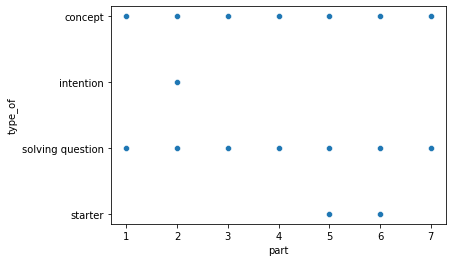

In [89]:
sns.scatterplot(data=lec, x= 'part', y='type_of')

Parts **1**,**3**, **4** and **7** only contain two types of lectures: **'solving question'** and **'concept'**. <br>
Part **2** is the only one to have an **'intention'** lecture. <br>
Parts **5** and **6** have an extra unique type of **'starter'** lectures. <br>
**All** parts contain **'solving question'** and **'concept'** lectures. 

In [92]:
questions = pd.read_csv("C:/Users/basx/Desktop/riiid-test-answer-prediction/questions.csv")

In [93]:
questions.head(20)

,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92
3,3,3,0,1,131 149 162 29
4,4,4,3,1,131 5 162 38
5,5,5,2,1,131 149 162 81
6,6,6,2,1,10 94 162 92
7,7,7,0,1,61 110 162 29
8,8,8,3,1,131 13 162 92
9,9,9,3,1,10 164 81


In [95]:
questions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13523 entries, 0 to 13522
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   question_id     13523 non-null  int64 
 1   bundle_id       13523 non-null  int64 
 2   correct_answer  13523 non-null  int64 
 3   part            13523 non-null  int64 
 4   tags            13522 non-null  object
dtypes: int64(4), object(1)
memory usage: 528.4+ KB


In [99]:
questions[['part','question_id']].groupby(['part'], as_index=False).count() # questions per part

,part,question_id
0,1,992
1,2,1647
2,3,1562
3,4,1439
4,5,5511
5,6,1212
6,7,1160


<AxesSubplot:xlabel='part', ylabel='Count'>

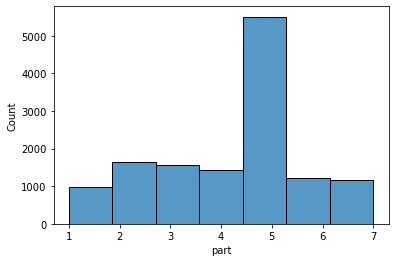

In [104]:
sns.histplot(data=questions, x = 'part', bins=7)

Questions are unevenly distributed among parts. With 5 being the clear winner. <br>
I presume this is some long-running course with a lot of practice, perhaps a language course with vocabulary questions.<br>
As for the rest of the parts the distribution is pretty even if we remove part 5.

In [105]:
questions[['correct_answer', 'question_id']].groupby(['correct_answer'], as_index=False).count()

,correct_answer,question_id
0,0,3716
1,1,3478
2,2,2785
3,3,3544


<AxesSubplot:xlabel='correct_answer', ylabel='Count'>

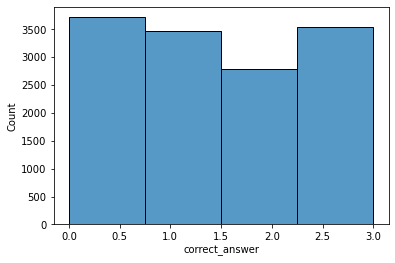

In [106]:
sns.histplot(data=questions, x='correct_answer', bins=4)

**IMPORTANT NOTE!**<br>
Remember, earlier, when we talked about the third answer variant (answer_variant == 2)? <br>
Previously we found out through analyzing train.csv, that this answer variant was least popular among the multiple-choice questions. <br>
Now, by looking at questions.csv we found out that, indeed, there was a bias when randomly distributing correct answers among the 4 bins (let's say a), b), c) and d)). The 'c)' bin contains a significintly smaller proportion of correct answers, when compared to the rest. <br> <br>
**If you don't know the answer to the question, don't choose 3rd answer variant, as you are less likely to land on a correct answer that way**

# Conclusion 
In conclusion, we have analyzed 3 sets of data: train.csv, lectures.csv, questions.csv. <br>
Some findings: <br>
98.1% of the content that students interacted with is questions; <br>
The questions are multiple choice questions with 4 variants of answers; <br>
The 3rd variant is the least popular variant of choice, by a significant amount;<br>
However it is not due to human psychology avoiding the 3rd variant, but rather due to uneven distribution of correct answers between the answer variants; <br>
65% of questions were answered correctly; <br>
Part 5 of the course had the most amount of questions by 2-3 times; <br>
If you don't know the answer to the question, don't choose 3rd answer variant, as you are less likely to land on a correct answer that way. <br>